---
categories : 
- librosa
title : "wave 파일 separate"
tags:
- mr 만들기
- 목소리 제거
- 악기트랙
- vocal remove
- vocal separate
last_modified_at:
---

In [2]:
%matplotlib inline


# Vocal separation

> 보컬을 분리하는 기술은 예전부터 hz를 이용한 방식으로 많이 사용되었는데 리브로사에서 기능을 제공한다.

This notebook demonstrates a simple technique for separating vocals (and
other sporadic foreground signals) from accompanying instrumentation.

This is based on the "REPET-SIM" method of [Rafii and Pardo, 2012](http://www.cs.northwestern.edu/~zra446/doc/Rafii-Pardo%20-%20Music-Voice%20Separation%20using%20the%20Similarity%20Matrix%20-%20ISMIR%202012.pdf), but includes a couple of modifications and extensions:

    - FFT windows overlap by 1/4, instead of 1/2
    - Non-local filtering is converted into a soft mask by Wiener filtering.
      This is similar in spirit to the soft-masking method used by [Fitzgerald, 2012](http://arrow.dit.ie/cgi/viewcontent.cgi?article=1086&context=argcon),
      but is a bit more numerically stable in practice.


In [3]:
# Code source: Brian McFee
# License: ISC

##################
# Standard imports
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio

import librosa

import librosa.display

# 한번 들어보자
librosa에 샘플에 음악이 들어있다. 예제를 불러와 사용해보겠다

In [13]:
y, sr = librosa.load(librosa.ex('fishin'))
Audio(y,rate=sr)

Load an example with vocals.



In [16]:
y, sr = librosa.load(librosa.ex('fishin'), duration=120)


# And compute the spectrogram magnitude and phase
S_full, phase = librosa.magphase(librosa.stft(y))

# 전주를 잘라내고 보컬이 들어있는 5초 정도만 사용한다.
Audio(data=y[11*sr:16*sr], rate=sr)

> 들어보면 기타소리와 보컬소리가 합쳐져 있다. 기타는 음역대가 보컬과 비슷해 잘못자르게 되면 손실이 많다. 자를때 주의가 필요하다.




In [31]:
slice(librosa.time_to_frames([11, 16], sr=sr))

slice(None, array([473, 689]), None)

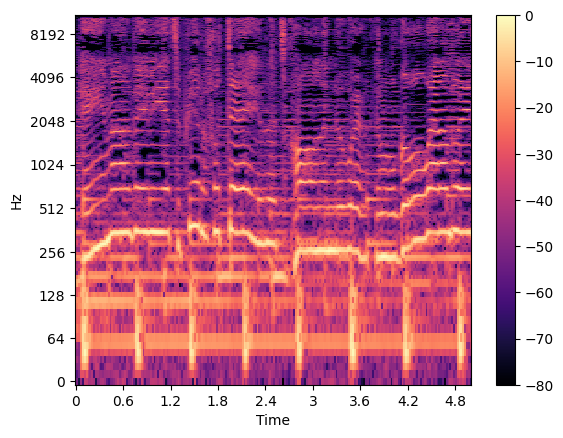

In [23]:
idx = slice(*librosa.time_to_frames([11, 16], sr=sr))
# librosa로 원하는 시간을 추출하고 slice를 해서 인덱스를 만든다.
fig, ax = plt.subplots()
img = librosa.display.specshow(librosa.amplitude_to_db(S_full[:, idx], ref=np.max),
                         y_axis='log', x_axis='time', sr=sr, ax=ax)
fig.colorbar(img, ax=ax)

The wiggly lines above are due to the vocal component.
Our goal is to separate them from the accompanying
instrumentation.




In [108]:
# 코사인 유사도를 이용하면 각도가 비슷한 라인을 잡아낼 수 있다. 이것을 이용해서 비슷한 라인을 모두 제거한다.
# We'll compare frames using cosine similarity, and aggregate similar frames
# by taking their (per-frequency) median value.
# 중앙값을 사용해서 분리하였지만 평균을 이용해도 잘된다.

# To avoid being biased by local continuity, we constrain similar frames to be
# separated by at least 2 seconds.
# 너무 잘개 자르면 유사한 기타라인까지 함께 제거가 될 수 있으므로 2초의 간격을 두고 잘라비교한다.
#
# This suppresses sparse/non-repetetitive deviations from the average spectrum,
# and works well to discard vocal elements.

S_filter = librosa.decompose.nn_filter(S_full,
                                       aggregate=np.median, # 뭔지 정확하게는 모르겠다. 중앙값으로 하면 잘나온다.
                                       metric='cosine',
                                       width=int(librosa.time_to_frames(20, sr=sr)))

# The output of the filter shouldn't be greater than the input
# if we assume signals are additive.  Taking the pointwise minimum
# with the input spectrum forces this.
S_filter = np.minimum(S_full, S_filter)
# 두값을 비교해서 작은 값만 취한다.

The raw filter output can be used as a mask,
but it sounds better if we use soft-masking.



In [109]:
# We can also use a margin to reduce bleed between the vocals and instrumentation masks.
# Note: the margins need not be equal for foreground and background separation
margin_i, margin_v = 2, 10
power = 2

mask_i = librosa.util.softmask(S_filter,
                               margin_i * (S_full - S_filter),
                               power=power)

mask_v = librosa.util.softmask(S_full - S_filter,
                               margin_v * S_filter,
                               power=power)

# Once we have the masks, simply multiply them with the input spectrum
# to separate the components

S_foreground = mask_v * S_full
S_background = mask_i * S_full

Plot the same slice, but separated into its foreground and background



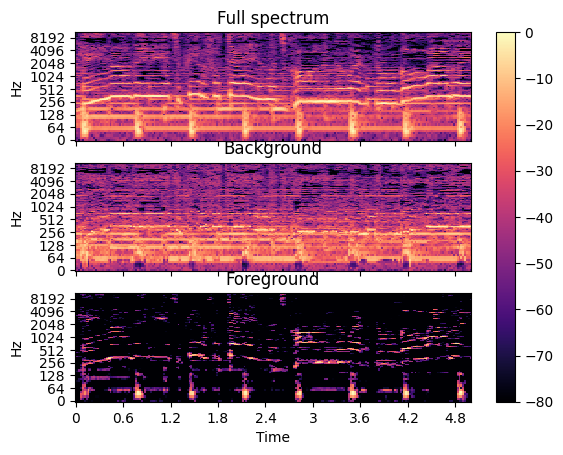

In [110]:
# sphinx_gallery_thumbnail_number = 2

fig, ax = plt.subplots(nrows=3, sharex=True, sharey=True)
img = librosa.display.specshow(librosa.amplitude_to_db(S_full[:, idx], ref=np.max),
                         y_axis='log', x_axis='time', sr=sr, ax=ax[0])
ax[0].set(title='Full spectrum')
ax[0].label_outer()

librosa.display.specshow(librosa.amplitude_to_db(S_background[:, idx], ref=np.max),
                         y_axis='log', x_axis='time', sr=sr, ax=ax[1])
ax[1].set(title='Background')
ax[1].label_outer()

librosa.display.specshow(librosa.amplitude_to_db(S_foreground[:, idx], ref=np.max),
                         y_axis='log', x_axis='time', sr=sr, ax=ax[2])
ax[2].set(title='Foreground')
fig.colorbar(img, ax=ax)

Recover the foreground audio from the masked spectrogram.
To do this, we'll need to re-introduce the phase information
that we had previously set aside.

In [112]:
y_foreground = librosa.istft(S_foreground * phase)
# Play back a 5-second excerpt with vocals
Audio(data=y_foreground[11*sr:16*sr], rate=sr)

In [113]:
y_background = librosa.istft(S_background * phase)
# Play back a 5-second excerpt with vocals
Audio(data=y_background[11*sr:16*sr], rate=sr)

# conclusion
> inst는 생각만큼 깨끗하게 따지지는 않았지만 이정도면 보컬만사용할때는 충분할것 같다.